In [1]:
import numpy as np
import matplotlib.pyplot as plt

Convergence is very fast. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool



In [3]:
PROCESSES = 32

def mom1(x):
    return np.mean(x)

def mom2(x):
    return np.mean(x**2)

def grad_proj(y, x, a, b):
    g1 = np.linalg.det(np.vstack([x-y, np.ones_like(x), y]))
    g2 = mom1(y) - a
    g3 = mom2(y) - b

def project(x, a, b, tol=1e-4):
    xp = np.zeros_like(x)
    unit_n = np.ones_like(x) / np.sqrt(len(x))
    a_n = np.ones_like(x) * a
    
    while np.linalg.norm(x-xp) >= tol:
        xp = x
        delta_x = x - a_n
        proj_n = np.dot(delta_x, unit_n) * unit_n
        x = x - proj_n
        x = x * np.sqrt(b / mom2(x))
    return x


def project_step(x, grad, delta, a, b, tol):
    return project(x + delta * grad, a, b, tol)

def get_func(x, lam, a, b, ys):
    #print(((grad_target_sum(x, ys) + get_constraint_jac(x).T @ lam.T)[:, None]).shape)
    return np.vstack([(grad_target_sum(x, ys) + get_constraint_jac(x).T @ lam.T)[:, None], 
                      get_constraint(x, a, b)])

def get_jac(x, lam, a, b, ys):
    hes = get_constraint_hess(x)
    gradLoss = np.eye(len(x)) + sum([l * h for l, h in zip(lam, hes)])
    gradConstr = get_constraint_jac(x)
    #print(gradLoss.shape, gradConstr.shape)

    return np.vstack([np.hstack([gradLoss, gradConstr.T]),
                      np.hstack([gradConstr, np.zeros((len(lam),len(lam)))]) 
                      ])

def get_constraint(x, a, b):
    return np.vstack([mom1(x)-a, 
                     mom2(x)-b])

def get_constraint_jac(x):
    return np.vstack([np.ones_like(x), 2*x])


def get_constraint_hess(x):
    n = len(x)
    return [np.zeros((n,n)), 2*np.ones((n,n))]

def newton(x, lam, a, b, ys, step=0.1, tol=1e-5):
    xp = np.zeros_like(x)
    x = xp + 0.001
    y = np.vstack([x[:, None], lam[:, None]])
    it = 0
    while np.linalg.norm(x-xp) >= tol:
        it += 1
        xp = x
        Jf = get_jac(x, lam, a, b, ys) 
        f = get_func(x, lam, a, b, ys)
        res = np.linalg.solve(Jf.T @ Jf, Jf.T @ f)
        if it % 100 == 0:
            print(it, x, np.linalg.norm(f))
        y = y - step * res
        x = y[:len(x)].flatten()
        lam = y[len(x):].flatten()
    return x.flatten()

def target(x, y):
    # target
    imin = 0
    val = mom2(x - y)
    for i in range(1, len(y)):
        new_val = mom2(x-np.roll(y, i))
        val = min(val, new_val)
        if val == new_val:
            imin = i
    return val, imin

def grad_target(x, y):
    # Grad wrt x
    val, imin = target(x, y)
    ry = np.roll(y, imin)
    return 2 * (x - ry)

def target_sum(x, ys):
    t = 0
    for y in ys:
        a, _ = target(x, y)#/len(ys)
        t += a/len(ys)#mom2(x - y) / len(ys)
    return t

def grad_target_pickled(args):
    return grad_target(args[0], args[1])

def grad_target_sum_pool(x, ys):
    p = Pool(PROCESSES)
    grad = np.zeros_like(x)
    out = p.map(grad_target_pickled, [(x, y) for y in ys])
    for o in out:
        grad += o / len(ys)
    return grad

def grad_target_sum(x, ys):
    grad = np.zeros_like(x)
    for y in ys:
        grad += grad_target(x, y) / len(ys)
    return grad

def projected_descent(x0, ys, delta, eps, maxit, tol, signal):
    flaty = ys.flatten()
    a = mom1(signal) #mom1(flaty)
    b = mom2(signal) #mom2(flaty)-eps**2
    x = x0
    for i in range(maxit):
        x0 = x
        grad = grad_target_sum(x, ys)
        x = project_step(x, -grad, delta, a, b, tol)
        print(np.linalg.norm(x - x0), end='\r')
    return x


def newton_iter(x0, ys, eps, delta, tol):
    flaty = ys.flatten()
    a = mom1(flaty)
    b = mom2(flaty)-eps**2
    x = newton(x0, np.ones(2,), a, b, ys, step=delta, tol=tol)
    return x


In [7]:
x = np.array([1., 1, 0]) 

N = 1e6
ys = np.zeros((N, 3))
eps = 2.
for n in range(N):
    ys[n, :] = np.roll(x, np.random.randint(0, 3)) + eps * np.random.randn(3)
    
#print(ys)
#m1 = mom1(ys.flattean())
#m2 = mom2(ys.flatten())
#print(m1)
#print(project(x, 1/3, 1/3, 1e-4))
#print(target(x, np.roll(x, 1)))

x0 = ys[0]
delta = 0.005
#x_rec = projected_descent(x0, ys, delta, eps, maxit=100, tol=1e-6, signal=x)
x_rec = newton_iter(x, ys, eps, delta, tol=1e-5)
print(x, x_rec)

100 [ 0.63681589 -2.94721786  2.61944646] 16373.838679137214
200 [ 0.73734282 -2.67625838  2.50981653] 9371.750960970461
300 [ 0.80995932 -2.4274158   2.40998334] 5403.593480027597
400 [ 0.88180963 -2.20677565  2.30506908] 3136.621161671489
500 [ 0.92138069 -2.0015771   2.21905722] 1831.7467033994085
600 [ 0.94299184 -1.81424895  2.14448477] 1075.474784418557
700 [ 0.95456113 -1.64505619  2.07744599] 634.4358863060737
800 [ 0.96038884 -1.49326845  2.01608181] 375.81460919069093
900 [ 0.96281065 -1.35772913  1.95958432] 223.42706908656686
1000 [ 0.96312947 -1.23713707  1.90762131] 133.25688539404513
1100 [ 0.96211372 -1.1301817   1.8600367 ] 79.706484047271
1200 [ 0.96025085 -1.03560314  1.81671059] 47.8030193705229
1300 [ 0.95787174 -0.95221499  1.77750311] 28.74359328340908
1400 [ 0.9552113  -0.87891033  1.74223822] 17.32973800560786
1500 [ 0.95243914 -0.81466094  1.7107048 ] 10.47975363996585
1600 [ 0.94967682 -0.75851449  1.68266403] 6.360755360250958
1700 [ 0.94700909 -0.70959156  

In [8]:
print("Rec",x_rec, mom1(x_rec), mom2(x_rec))
print("True",x, mom1(x), mom2(x))
print("Data", mom1(ys.flatten()), mom2(ys.flatten())-eps**2)
print("Rec", target_sum(x_rec, ys))
print("True", target_sum(x, ys))

Rec [ 0.92569565 -0.41518886  1.50107085] 0.6705258788176619 1.0941693067849518
True [1. 1. 0.] 0.6666666666666666 0.6666666666666666
Data 0.6711467300333428 1.089543554514437
Rec 3.102043594907103
True 3.597451879315316


In [9]:
x = np.array([1., 1., 0])
a = mom1(x)
b = mom2(x)


def rad_cent(a, b):
    #c0 = np.array([0, 0, 0])
    n = np.array([1., 1., 1.])
    e1 = np.array([1, -1, 0])
    e1 = e1/ np.linalg.norm(e1)
    e2 = np.array([1, 1, -2])
    e2 = e2/ np.linalg.norm(e2)
    return np.sqrt(3 * b - 3 * a**2), a * n, e1, e2

r, n, e1, e2 = rad_cent(a,b)

theta = np.linspace(0, 2*np.pi, 100)[:, None]

x = np.cos(theta) * e1[None, :] * r + np.sin(theta) * e2[None, :] * r + n  
loss = []
for x_elm in x: 
    s = target_sum(x_elm, ys)
    loss.append(s)

[ 0.92569565 -0.41518886  1.50107085]


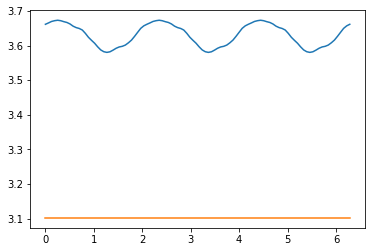

In [10]:
plt.plot(theta, loss)

s = target_sum(x_rec, ys)
plt.plot(theta, s  + theta * 0)
print(x_rec)

Example: Robin conditions on second order diff equation on the line:

\begin{equation}
       y''(x) + y(x) = 1,\; x \in [0, 1] \qquad y'(0) + y(0) = y'(1) + y(1) = 0
\end{equation}



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


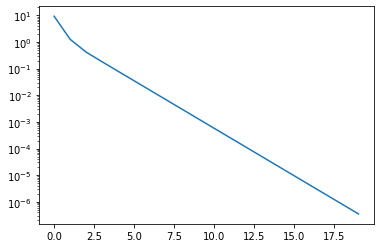

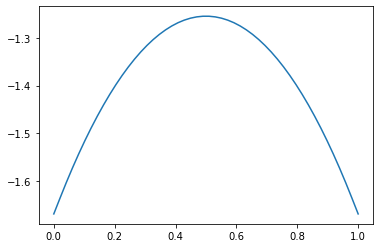

In [12]:
N = 50
h = 1/(N-1)
x = np.linspace(0, 1, N)

# Construct system matrices
A = -np.diag(np.ones((N-3,)), k=-1)
A = (A + np.diag(2*np.ones((N-2,)), k=0) + A.T)
A = np.eye(N-2)*h**2 + A

A_dir = A
A_neu = A.copy()
A_neu[0,0] -= 1
A_neu[-1,-1] -= 1

def get_rhs(a,b):
    rhs = np.ones((N-2,)) * h**2
    rhs[0] += -a 
    rhs[-1] += -b
    return rhs

def solve_dir(rhs):
    u = np.zeros((N,))
    u[1:-1] = np.linalg.solve(A_dir, rhs)
    u[0] = rhs[0]
    u[-1] = rhs[-1]
    return u

def solve_neu(rhs):
    u = np.zeros((N,))
    u[1:-1] = np.linalg.solve(A_neu, rhs)
    # Extrap.
    u[0] = u[1] - rhs[0] * h
    u[-1] = u[-2] + rhs[-1] * h
    return u



u_d = np.sin(x)
u_n = np.sin(x)

u_d_tmp = u_d.copy()
error = []

for i in range(20):
    print(i, end='\r')
    # Update boundaries
    rhs_d = get_rhs(-10*(u_n[1]-u_n[0])+1, 10*(u_n[-1] - u_n[-2])+1)
    #rhs_n = get_rhs(-u_d[0], -u_d[-1])
    #rhs_n = get_rhs(- (u_d[1]-u_d[0]), -(u_d[-1] - u_d[-2]))
    
    # Solve system
    #u_d = solve_dir(rhs_d)
    #u_n = solve_neu(rhs_n)
    u_n = solve_dir(rhs_d)
    u_d = u_n
    
    error.append(np.linalg.norm(u_d_tmp - u_d))
    u_d_tmp = u_d.copy()

plt.semilogy(np.abs(error))

plt.figure()
plt.plot(x, u_d+u_n)




#def solve_dir(, a, b)

In [9]:
u_n

array([0.00914259, 0.01786868, 0.02660221, 0.03493034, 0.04285651,
       0.05038405, 0.05751607, 0.06425556, 0.07060531, 0.07656798,
       0.08214605, 0.08734183, 0.0921575 , 0.09659506, 0.10065636,
       0.10434309, 0.10765678, 0.11059882, 0.11317043, 0.11537268,
       0.11720649, 0.11867262, 0.11977168, 0.12050414, 0.12087029,
       0.12087029, 0.12050414, 0.11977168, 0.11867262, 0.11720649,
       0.11537268, 0.11317043, 0.11059882, 0.10765678, 0.10434309,
       0.10065636, 0.09659506, 0.0921575 , 0.08734183, 0.08214605,
       0.07656798, 0.07060531, 0.06425556, 0.05751607, 0.05038405,
       0.04285651, 0.03493034, 0.02660221, 0.01786868, 0.00914259])